In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import FuntionUtils as cf
import math

import matplotlib
import seaborn
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
df = pd.read_csv("TempData.csv")


In [3]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


In [4]:
# ------Data preparation -----
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
#df.plot(x='timestamp', y='value')
# the hours and if it's night or day (7:00-22:00)
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [5]:
df.head()

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104


In [6]:
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

In [7]:
# calculer avec un nombre différent de centroïdes pour voir la courbe de perte (méthode du coude)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
#fig, ax = plt.subplots()
#ax.plot(n_cluster, scores)
#plt.show()

In [8]:
# I choose 7 centroids arbitrarily and add these data to the central dataframe
df['cluster'] = kmeans[7].predict(data) #
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
#df['cluster'].value_counts()

In [9]:
#data

<IPython.core.display.Javascript object>


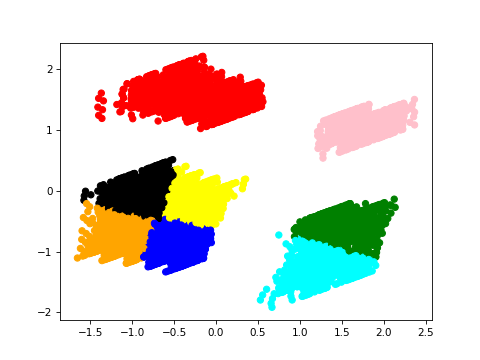

In [10]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [11]:
# obtenir la distance entre chaque point et son centroïde le plus proche. Les plus grandes distances sont considérées comme une anomalie
distance = cf.getDistanceByPoint(data, kmeans[14])
# Une estimation de la population anormale de l'ensemble de données 1%
outliers_fraction = 0.01
number_of_outliers = int(outliers_fraction*len(data)) #1% de la population maximum
threshold = distance.nlargest(number_of_outliers).min() #retourne la distance la plus petite parmis les n="number_of_outlier" plus grandes distances
# anomalie21 contient le résultat d'anomalie de la méthode 2.1 Cluster (0:normal, 1:anomalie) 
df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\MARIEM\OutlierDetection-pfe\FuntionUtils.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  distance.set_value(i, np.linalg.norm(Xa-Xb))


In [12]:
df[df['anomaly21'] ==1] 

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
734,2013-08-04 22:00:00,20.237879,22,1,6,0,13756536,6,1.441014,-1.528474,1
1214,2013-08-24 22:00:00,19.472060,22,1,5,0,13773816,6,1.256912,-1.431905,1
1527,2013-09-08 22:00:00,20.480328,22,1,6,0,13786776,6,1.421382,-1.538288,1
1702,2013-09-22 20:00:00,21.126957,20,1,6,0,13798800,6,1.399722,-1.409196,1
1703,2013-09-22 21:00:00,21.278405,21,1,6,0,13798836,6,1.372108,-1.492959,1
...,...,...,...,...,...,...,...,...,...,...,...
6171,2014-04-13 00:00:00,15.511915,0,0,6,0,13973472,3,2.363768,1.500610,1
6172,2014-04-13 01:00:00,15.607523,1,0,6,0,13973508,3,2.340676,1.419107,1
6337,2014-04-19 22:00:00,17.992409,22,1,5,0,13979448,6,1.376726,-1.372012,1
6505,2014-04-26 22:00:00,18.106119,22,1,5,0,13985496,6,1.367519,-1.376614,1


<IPython.core.display.Javascript object>


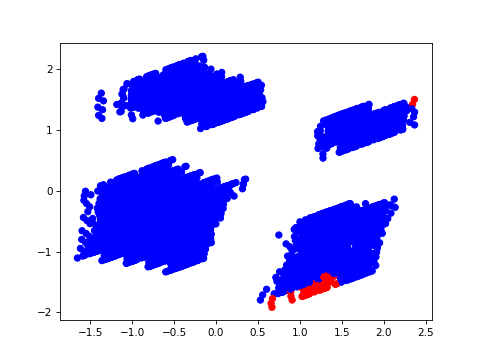

In [13]:
# visualisation de l'anomalie avec cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

<IPython.core.display.Javascript object>


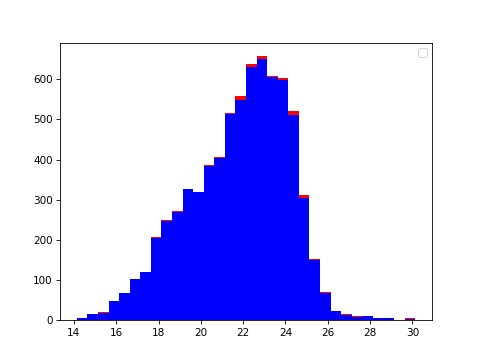

No handles with labels found to put in legend.


In [14]:
# visualisation de l'anomalie avec répartition de la température
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

In [15]:
#------------DBSCAN----------------
from sklearn.cluster import DBSCAN
DB = DBSCAN(eps=0.1, min_samples=25)
DB.fit(data)

from collections import Counter
print(Counter(DB.labels_))

#data[DB.labels_==-1]

Counter({1: 3676, 0: 1451, 3: 1325, 2: 559, -1: 256})


In [16]:
b = df[df['anomaly21']==1]

In [17]:
Anomaly=b.loc[:,['principal_feature1', 'principal_feature2']]

In [18]:
Anomaly

,principal_feature1,principal_feature2
734,1.441014,-1.528474
1214,1.256912,-1.431905
1527,1.421382,-1.538288
1702,1.399722,-1.409196
1703,1.372108,-1.492959
...,...,...
6171,2.363768,1.500610
6172,2.340676,1.419107
6337,1.376726,-1.372012
6505,1.367519,-1.376614


In [19]:
l=data[DB.labels_==-1]

In [20]:
l.columns = ['principal_feature1', 'principal_feature2']

In [21]:
len(Anomaly)

72

In [22]:
intersected_df = pd.merge(l, Anomaly, how='inner')
#print(intersected_df)

In [31]:
data

,0,1
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262
...,...,...
7262,-0.663130,-0.218870
7263,-0.669607,-0.292067
7264,-0.679271,-0.366858
7265,-0.684664,-0.439514


In [32]:
data.columns = ['principal_feature1','principal_feature2']

In [33]:
data.head()

,principal_feature1,principal_feature2
0,0.066191,1.755363
1,-0.009413,1.647609
2,-0.009359,1.577677
3,0.061592,1.543184
4,0.031660,1.458262


## distance entre les points

In [34]:
dictDistance ={}
for index, row in data.iterrows():
    dictDistance[index]=[] 
    #print( row['principal_feature1'], row['principal_feature1'])

In [35]:
#dictDistance

In [36]:
DictClusters={}

In [37]:
for i in range(7):
    DictClusters[i]=[]
    

In [38]:
DictClusters

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: []}

In [39]:
#afficher les points du premier cluster
cluster0 = df.loc[df['cluster']==0,:]

In [40]:
cluster0

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
103,2013-07-08 07:00:00,16.778049,7,1,0,1,13732668,0,-0.636465,0.451497,0
104,2013-07-08 08:00:00,17.212671,8,1,0,1,13732704,0,-0.687008,0.356272,0
105,2013-07-08 09:00:00,18.026739,9,1,0,1,13732740,0,-0.768277,0.245686,0
106,2013-07-08 10:00:00,18.518304,10,1,0,1,13732776,0,-0.823431,0.148156,0
107,2013-07-08 11:00:00,19.173858,11,1,0,1,13732812,0,-0.891865,0.043987,0
...,...,...,...,...,...,...,...,...,...,...,...
7250,2014-05-27 23:00:00,20.548310,23,0,1,1,14012316,0,-0.738877,0.121042,0
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,0,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,0,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,0,-0.679271,-0.366858,0


In [41]:
#DicIndex contient chaque cluster: l'indice des points qui lui appartient
DictIndex={}
for i in range(7):
    DictIndex[i]=[]
    

In [42]:
l=[]
indice=[]
for index, row in cluster0.iterrows():
    indice.append(index)
    l.append([row['principal_feature1'], row['principal_feature1']])
DictIndex[0]=indice

In [43]:
DictClusters[0]=l

In [44]:
#DictIndex[0]

In [45]:
cluster1 = df.loc[df['cluster']==1,:]
l=[]
indice =[]

for index, row in cluster1.iterrows():
    indice.append(index)
    l.append([row['principal_feature1'], row['principal_feature1']])
DictClusters[1]=l
DictIndex[1]=indice

In [46]:
cluster0

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
103,2013-07-08 07:00:00,16.778049,7,1,0,1,13732668,0,-0.636465,0.451497,0
104,2013-07-08 08:00:00,17.212671,8,1,0,1,13732704,0,-0.687008,0.356272,0
105,2013-07-08 09:00:00,18.026739,9,1,0,1,13732740,0,-0.768277,0.245686,0
106,2013-07-08 10:00:00,18.518304,10,1,0,1,13732776,0,-0.823431,0.148156,0
107,2013-07-08 11:00:00,19.173858,11,1,0,1,13732812,0,-0.891865,0.043987,0
...,...,...,...,...,...,...,...,...,...,...,...
7250,2014-05-27 23:00:00,20.548310,23,0,1,1,14012316,0,-0.738877,0.121042,0
7262,2014-05-28 11:00:00,22.427892,11,1,2,1,14012748,0,-0.663130,-0.218870,0
7263,2014-05-28 12:00:00,22.318309,12,1,2,1,14012784,0,-0.669607,-0.292067,0
7264,2014-05-28 13:00:00,22.248092,13,1,2,1,14012820,0,-0.679271,-0.366858,0


In [47]:
cluster1 = df.loc[df['cluster']==1,:]
cluster1

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
55,2013-07-06 07:00:00,21.071795,7,1,5,0,13730940,1,1.357624,-0.332163,0
56,2013-07-06 08:00:00,20.714305,8,1,5,0,13730976,1,1.371221,-0.395325,0
57,2013-07-06 09:00:00,20.959104,9,1,5,0,13731012,1,1.336049,-0.482867,0
58,2013-07-06 10:00:00,20.105613,10,1,5,0,13731048,1,1.389810,-0.525953,0
59,2013-07-06 11:00:00,20.509331,11,1,5,0,13731084,1,1.341769,-0.619928,0
...,...,...,...,...,...,...,...,...,...,...,...
7194,2014-05-25 15:00:00,16.120916,15,1,6,0,14010300,1,1.881835,-0.818395,0
7195,2014-05-25 16:00:00,16.772591,16,1,6,0,14010336,1,1.813715,-0.922407,0
7196,2014-05-25 17:00:00,16.844461,17,1,6,0,14010372,1,1.792546,-1.002949,0
7197,2014-05-25 18:00:00,16.246925,18,1,6,0,14010408,1,1.825581,-1.056395,0


In [48]:
cluster2 = df.loc[df['cluster']==2,:]
l=[]
indice =[]
for index, row in cluster2.iterrows():
    indice.append(index)
    l.append([row['principal_feature1'], row['principal_feature1']])
DictClusters[2]=l
DictIndex[2]=indice

In [49]:
cluster2 = df.loc[df['cluster']==2,:]
cluster2

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
0,2013-07-04 00:00:00,21.044908,0,0,3,1,13728960,2,0.066191,1.755363,0
1,2013-07-04 01:00:00,21.789015,1,0,3,1,13728996,2,-0.009413,1.647609,0
2,2013-07-04 02:00:00,21.598781,2,0,3,1,13729032,2,-0.009359,1.577677,0
3,2013-07-04 03:00:00,20.533000,3,0,3,1,13729068,2,0.061592,1.543184,0
4,2013-07-04 04:00:00,20.713084,4,0,3,1,13729104,2,0.031660,1.458262,0
...,...,...,...,...,...,...,...,...,...,...,...
7253,2014-05-28 02:00:00,19.182731,2,0,2,1,14012424,2,-0.059834,1.741044,0
7254,2014-05-28 03:00:00,19.809068,3,0,2,1,14012460,2,-0.125902,1.638058,0
7255,2014-05-28 04:00:00,18.746277,4,0,2,1,14012496,2,-0.055193,1.603444,0
7256,2014-05-28 05:00:00,19.022433,5,0,2,1,14012532,2,-0.092904,1.514633,0


In [50]:
cluster3 = df.loc[df['cluster']==3,:]
indice =[]
l=[]
for index, row in cluster3.iterrows():
    l.append([row['principal_feature1'], row['principal_feature1']])
    indice.append(index)
DictClusters[3]=l
DictIndex[3]=indice

In [51]:
cluster3 = df.loc[df['cluster']==3,:]
cluster3

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
15,2013-07-04 15:00:00,22.024051,15,1,3,1,13729500,3,-0.445715,-0.578625,0
16,2013-07-04 16:00:00,21.803144,16,1,3,1,13729536,3,-0.443177,-0.647317,0
17,2013-07-04 17:00:00,21.525055,17,1,3,1,13729572,3,-0.436009,-0.713693,0
18,2013-07-04 18:00:00,21.874055,18,1,3,1,13729608,3,-0.479619,-0.805453,0
19,2013-07-04 19:00:00,22.108750,19,1,3,1,13729644,3,-0.513973,-0.892586,0
...,...,...,...,...,...,...,...,...,...,...,...
7150,2014-05-23 19:00:00,22.398667,19,1,4,1,14008716,3,-0.291334,-0.969892,0
7151,2014-05-23 20:00:00,22.759639,20,1,4,1,14008752,3,-0.335914,-1.062136,0
7152,2014-05-23 21:00:00,22.762678,21,1,4,1,14008788,3,-0.351510,-1.139892,0
7153,2014-05-23 22:00:00,21.902119,22,1,4,1,14008824,3,-0.297177,-1.182692,0


In [52]:
#df

In [53]:
cluster4 = df.loc[df['cluster']==4,:]
l=[]
indice =[]
for index, row in cluster4.iterrows():
    l.append([row['principal_feature1'], row['principal_feature1']])
    indice.append(index)
DictClusters[4]=l
DictIndex[4]=indice

In [54]:
cluster4 = df.loc[df['cluster']==4,:]
cluster4

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
48,2013-07-06 00:00:00,22.017202,0,0,5,0,13730688,4,1.590889,1.302858,0
49,2013-07-06 01:00:00,21.442631,1,0,5,0,13730724,4,1.622065,1.248483,0
50,2013-07-06 02:00:00,21.584712,2,0,5,0,13730760,4,1.595210,1.165099,0
51,2013-07-06 03:00:00,21.713760,3,0,5,0,13730796,4,1.569410,1.082242,0
52,2013-07-06 04:00:00,21.581796,4,0,5,0,13730832,4,1.564746,1.009950,0
...,...,...,...,...,...,...,...,...,...,...,...
7181,2014-05-25 02:00:00,16.566666,2,0,6,0,14009832,4,2.247660,1.302649,0
7182,2014-05-25 03:00:00,16.462841,3,0,6,0,14009868,4,2.240717,1.229219,0
7183,2014-05-25 04:00:00,17.025287,4,0,6,0,14009904,4,2.179823,1.128819,0
7184,2014-05-25 05:00:00,16.869787,5,0,6,0,14009940,4,2.177065,1.057480,0


In [55]:
cluster5 = df.loc[df['cluster']==5,:]
l=[]
indice =[]
for index, row in cluster5.iterrows():
    l.append([row['principal_feature1'], row['principal_feature1']])
    indice.append(index)
DictClusters[5]=l
DictIndex[5]=indice

In [56]:
cluster5 = df.loc[df['cluster']==5,:]
cluster5

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
64,2013-07-06 16:00:00,19.780679,16,1,5,0,13731264,5,1.324021,-0.978599,0
65,2013-07-06 17:00:00,19.542562,17,1,5,0,13731300,5,1.327953,-1.046593,0
66,2013-07-06 18:00:00,19.995856,18,1,5,0,13731336,5,1.275898,-1.142575,0
67,2013-07-06 19:00:00,19.587878,19,1,5,0,13731372,5,1.293584,-1.203694,0
68,2013-07-06 20:00:00,19.218933,20,1,5,0,13731408,5,1.308109,-1.266393,0
...,...,...,...,...,...,...,...,...,...,...,...
7177,2014-05-24 22:00:00,16.834097,22,1,5,0,14009688,5,1.470520,-1.325125,0
7198,2014-05-25 19:00:00,16.137000,19,1,6,0,14010444,5,1.819132,-1.129579,0
7199,2014-05-25 20:00:00,16.920085,20,1,6,0,14010480,5,1.740372,-1.238910,0
7200,2014-05-25 21:00:00,16.026475,21,1,6,0,14010516,5,1.797382,-1.280371,0


In [57]:
cluster6 = df.loc[df['cluster']==6,:]
l=[]
indice =[]
for index, row in cluster6.iterrows():
    l.append([row['principal_feature1'], row['principal_feature1']])
    indice.append(index)
DictClusters[6]=l
DictIndex[6]=indice

In [58]:
cluster6 = df.loc[df['cluster']==6,:]
cluster6

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
7,2013-07-04 07:00:00,20.760894,7,1,3,1,13729212,6,-0.220631,0.093570,0
8,2013-07-04 08:00:00,20.648174,8,1,3,1,13729248,6,-0.226853,0.020499,0
9,2013-07-04 09:00:00,20.547824,9,1,3,1,13729284,6,-0.234077,-0.053072,0
10,2013-07-04 10:00:00,21.091701,10,1,3,1,13729320,6,-0.293468,-0.152720,0
11,2013-07-04 11:00:00,21.420108,11,1,3,1,13729356,6,-0.335410,-0.243647,0
...,...,...,...,...,...,...,...,...,...,...,...
7234,2014-05-27 07:00:00,17.576647,7,1,1,1,14011740,6,-0.455016,0.353602,0
7258,2014-05-28 07:00:00,18.692152,7,1,2,1,14012604,6,-0.299229,0.242878,0
7259,2014-05-28 08:00:00,19.706982,8,1,2,1,14012640,6,-0.396755,0.124167,0
7260,2014-05-28 09:00:00,20.018378,9,1,2,1,14012676,6,-0.437320,0.033929,0


In [59]:
cluster7 = df.loc[df['cluster']==7,:]
cluster7

,timestamp,value,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,cluster,principal_feature1,principal_feature2,anomaly21
112,2013-07-08 16:00:00,21.289074,16,1,0,1,13732992,7,-1.139894,-0.429798,0
113,2013-07-08 17:00:00,21.380854,17,1,0,1,13733028,7,-1.162676,-0.511146,0
114,2013-07-08 18:00:00,22.410168,18,1,0,1,13733064,7,-1.261374,-0.630444,0
115,2013-07-08 19:00:00,21.772680,19,1,0,1,13733100,7,-1.225104,-0.682273,0
116,2013-07-08 20:00:00,21.533277,20,1,0,1,13733136,7,-1.221068,-0.750216,0
...,...,...,...,...,...,...,...,...,...,...,...
7245,2014-05-27 18:00:00,21.845799,18,1,1,1,14012136,7,-0.969560,-0.673170,0
7246,2014-05-27 19:00:00,21.939016,19,1,1,1,14012172,7,-0.992458,-0.754576,0
7247,2014-05-27 20:00:00,22.118597,20,1,1,1,14012208,7,-1.022350,-0.839478,0
7248,2014-05-27 21:00:00,20.972345,21,1,1,1,14012244,7,-0.944882,-0.870713,0


In [60]:
cluster7 = df.loc[df['cluster']==7,:]
l=[]
indice =[]
for index, row in cluster5.iterrows():
    l.append([row['principal_feature1'], row['principal_feature1']])
    indice.append(index)
DictClusters[7]=l
DictIndex[7]=indice

In [61]:
#DictIndex

In [62]:
#len(dictDistance)

In [63]:
len(DictClusters)

8

In [64]:
DictClusters[7]

[[1.3240214483211783, 1.3240214483211783],
 [1.3279529769016583, 1.3279529769016583],
 [1.2758975804833506, 1.2758975804833506],
 [1.2935835039273929, 1.2935835039273929],
 [1.3081087548089798, 1.3081087548089798],
 [1.2354250716659703, 1.2354250716659703],
 [1.2460030564313558, 1.2460030564313558],
 [1.6937056838764348, 1.6937056838764348],
 [1.7241901191472597, 1.7241901191472597],
 [1.6985015718578644, 1.6985015718578644],
 [1.6560030507161747, 1.6560030507161747],
 [1.699836562917093, 1.699836562917093],
 [1.3068883442284709, 1.3068883442284709],
 [1.2742468206049427, 1.2742468206049427],
 [1.226567917840823, 1.226567917840823],
 [1.2249219316166629, 1.2249219316166629],
 [1.197002412054932, 1.197002412054932],
 [1.2156766601833842, 1.2156766601833842],
 [1.2438594249973807, 1.2438594249973807],
 [1.1618148669429846, 1.1618148669429846],
 [1.6289463444553103, 1.6289463444553103],
 [1.585511800242422, 1.585511800242422],
 [1.5427094392168668, 1.5427094392168668],
 [1.547453181772859

In [65]:
#DSC LA Liste des listes des distances de chaque point aux autre points dans le même cluster
DSC=[]
for j in range(len(DictClusters)):
    for i in range (len(DictClusters[j])):
        distances=[]
        for k in range (len(DictClusters[j])):
            distance0=cf.distance_points(DictClusters[j][i],DictClusters[j][k])
            distances.append(distance0)
        DSC.append(distances)
        i+=1

    

In [66]:
#len(DSC)

In [67]:
clusterDistance0=DSC[0:len(cluster0)]
clusterDistance1=DSC[len(cluster0):len(cluster0)+len(cluster1)]
clusterDistance2=DSC[len(cluster0)+len(cluster1):len(cluster0)+len(cluster1)+len(cluster2)]
clusterDistance3=DSC[len(cluster0)+len(cluster1)+len(cluster2):len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)]
clusterDistance4=DSC[len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3):len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)]
clusterDistance5=DSC[len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4):len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)+len(cluster5)]
clusterDistance6=DSC[len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)+len(cluster5):len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)+len(cluster5)+len(cluster6)]
clusterDistance7=DSC[len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)+len(cluster5)+len(cluster6):len(cluster0)+len(cluster1)+len(cluster2)+len(cluster3)+len(cluster4)+len(cluster5)+len(cluster6)+len(cluster7)]



In [75]:
#clusterDistances=[]
clusterDistances.append(clusterDistance7)

In [76]:
type(clusterDistances[0][0][0])

float

In [77]:
#for j in range(len(DictClusters)):
    #print(len(DictClusters[j]))

In [78]:
import statistics 
MaxPoints={}
for i in range (len(clusterDistances)):
    MaxPoints[i]=i


In [79]:
MaxPoints

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [80]:
 for i in range (len(clusterDistances)):
    L=[]
    for j in range (len(clusterDistances[i])):
        L.append(statistics.mean(clusterDistances[i][j]))
    MaxPoints[i]=L 
    

In [85]:
for i in range (len(clusterDistances)):
    L=[]
    for j in range (len(clusterDistances[i])):
        for k in range(len(clusterDistances[i][j])):
            L.append(clusterDistances[i][k].index(max(clusterDistances[i][k])))
    MaxPoints[i]=L   

In [86]:
for j in range(len(MaxPoints)):
    print(MaxPoints[j].index(max(MaxPoints[j])))

8
0
49
3
0
16
0
16


## Méthode boîte à moustaches

<IPython.core.display.Javascript object>


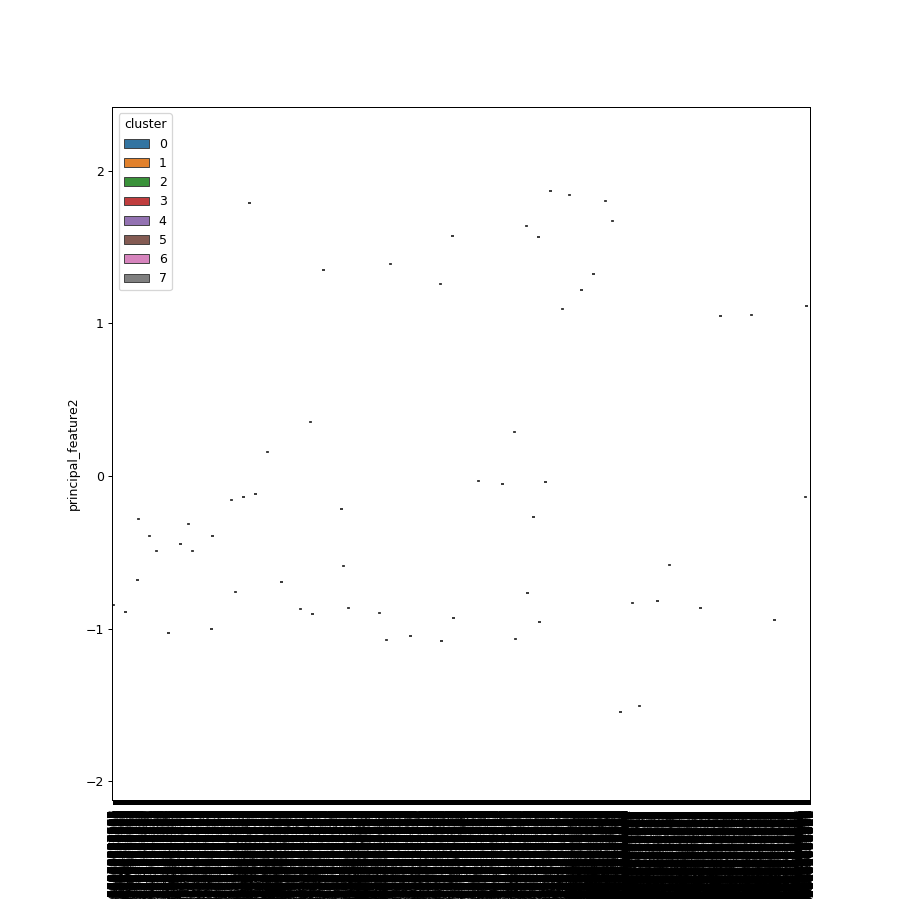

(array([   0,    1,    2, ..., 7264, 7265, 7266]),
 <a list of 7267 Text xticklabel objects>)

In [98]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.boxplot(x="principal_feature1", y="principal_feature2", hue="cluster", data=df)
plt.xticks(rotation=90)

## Isolation Forest

In [87]:
from sklearn.ensemble import IsolationForest
# Prendre des caractéristiques utiles et les normaliser 
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    7194
1      73
Name: anomaly25, dtype: int64


<IPython.core.display.Javascript object>


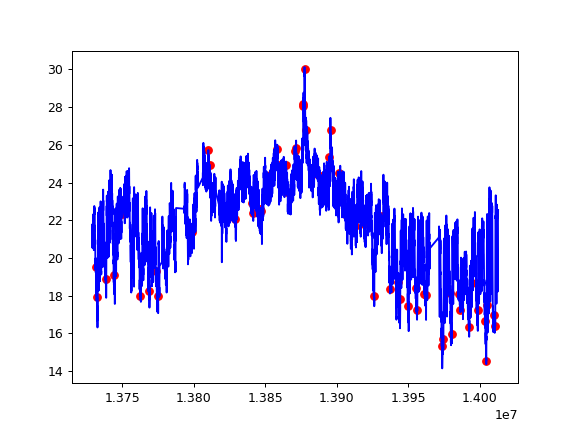

In [88]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly25'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

<IPython.core.display.Javascript object>


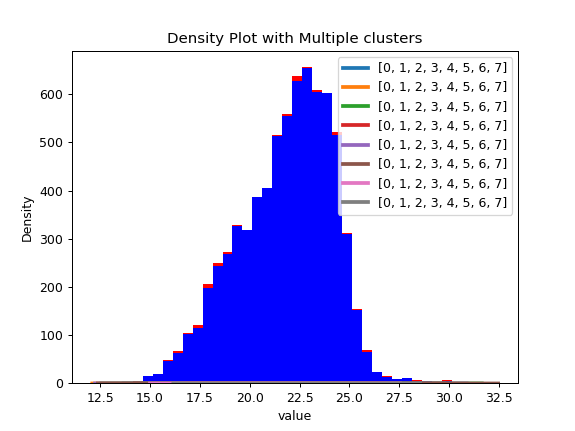

No handles with labels found to put in legend.


In [89]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.legend()
plt.show()

## Density 

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0,1,2,3,4,5,6,7]

# Itération par les 8 classes
for classe in classes:
    # Subset to the airline
    subset = df[df['cluster'] == classe]
    
    # Dessiner le diagramme de densité
    sns.distplot(subset['value'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = classes)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Cluster')
plt.title('Density Plot with Multiple clusters')
plt.xlabel('value')
plt.ylabel('Density')
plt.legend()
plt.show() 

## Methode des quantiles

In [99]:
import numpy as np 
   
# 2D array  
arr = data.to_numpy()
print("\n data : \n", arr)  
     
# quantile 
print("\n50th quantile of data, axis = None : ", np.quantile(arr, .50))  
print("0th quantile of data, axis = None : ", np.quantile(arr, 0))
print("\n98th quantile of data, axis = None : ", np.quantile(arr, .98))  



 data : 
 [[-0.32058581 -1.66153683 -1.41479759  0.00576899  0.62131999]
 [-0.00522828 -1.51717197 -1.41479759  0.00576899  0.62131999]
 [-0.08585098 -1.37280711 -1.41479759  0.00576899  0.62131999]
 ...
 [ 0.18933168  0.21520635  0.70681489 -0.49933023  0.62131999]
 [ 0.13721779  0.35957121  0.70681489 -0.49933023  0.62131999]
 [ 0.31589058  0.50393607  0.70681489 -0.49933023  0.62131999]]

50th quantile of data, axis = None :  0.5039360673437011
0th quantile of data, axis = None :  -3.2454255581920695

98th quantile of data, axis = None :  1.5210666379522744
